In [1]:
%load_ext autoreload
%autoreload
from mutabledataset import GermanSimDataset
from agent import RationalAgent
from simulation import Simulation
from learner import LogisticLearner

import plot
import numpy as np
import pandas as pd


import nest_asyncio
nest_asyncio.apply()

def print_table(df):
    young = plot.count_df(df, [{'age': 0, 'credit_h': 1}, {'age': 0, 'credit_h': 0}])
    young_n = young.sum()
    young = young / young.sum() * 100

    old = plot.count_df(df, [{'age': 1, 'credit_h': 1}, {'age': 1, 'credit_h': 0}])
    old_n = old.sum()
    old = old / old.sum() * 100
    tbl = pd.DataFrame(data=[young,old], index=['Young ('+str(young_n)+')', 'Old ('+str(old_n)+')'], columns=['Good Credit', 'Bad Credit'])
    return (tbl)
    #plot.plot_pie(sim.dataset_df, [{'age': 0, 'credit_h': 1},
    #                               {'age': 0, 'credit_h': 0}],
    #              ['Good', 'Bad'], 'Young')

    #plot.plot_pie(sim.dataset_df, [{'age': 1, 'credit_h': 1},
    #                               {'age': 1, 'credit_h': 0}],
    #              ['Good', 'Bad'], 'Old')

    #plot.plot_pie(sim.dataset_new_df, [{'age': 0, 'credit_h': 1},
    #                               {'age': 0, 'credit_h': 0}],
    #              ['Good', 'Bad'], 'Young')

    #plot.plot_pie(sim.dataset_new_df, [{'age': 1, 'credit_h': 1},
    #                               {'age': 1, 'credit_h': 0}],
    #              ['Good', 'Bad'], 'Old')



# Logistic Regression

In [24]:

g = GermanSimDataset(mutable_features=['savings'],
                     domains={'savings': 'auto'},
                     discrete=['savings'])
sim = Simulation(g,
                 RationalAgent,
                 LogisticLearner(),
                 lambda size: np.abs(np.random.normal(loc=1.0,size=size)))
 
sim.start_simulation(include_protected=True)


Train:  (500, 58) , Test:  (500, 58)


/home/dan/data/ETH/ba/simulation/mutabledataset.py:84: UserWarning: Use set of values present in dataset to infer domain for feature savings
  warnings.warn("Use set of values present in dataset to infer domain for feature " + ft)


Accuracy (h) pre 0.724
Accuracy (h) post 0.772
Accuracy (h*) post 0.778
eps =  0.01
y=1 777.0  <-  700.0


In [2]:
df,_ = sim.train.convert_to_dataframe(de_dummy_code=True)
print(np.array(df['age'] == 0).sum())

Train:  (500, 58) , Test:  (500, 58)
ERROR! Session/line number was not unique in database. History logging moved to new session 54


/home/dan/data/ETH/ba/simulation/mutabledataset.py:84: UserWarning: Use set of values present in dataset to infer domain for feature savings
  warnings.warn("Use set of values present in dataset to infer domain for feature " + ft)


72


### Mutable Features

young


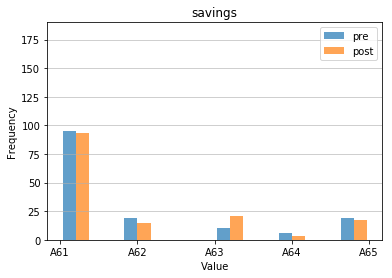

old


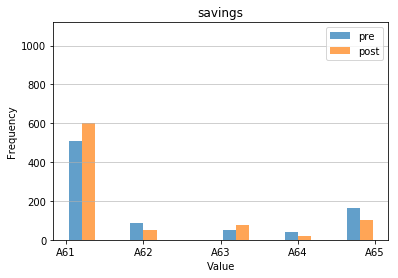

In [6]:
print("young")
plot.plot_mutable_features(sim,selection_criteria={'age':0})
print("old")
plot.plot_mutable_features(sim,selection_criteria={'age':1})

### Young, Old (Pre Simulation)

In [10]:
print_table(sim.dataset_df)

,Good Credit,Bad Credit
Young (149),71.140940,28.859060
Old (851),78.613396,21.386604


### Young, Old (Post Simulation)

In [11]:
print_table(sim.dataset_new_df)

,Good Credit,Bad Credit
Young (149),87.919463,12.080537
Old (851),88.836663,11.163337


# Logistic Regression with Reweighing

In [12]:
from learner import ReweighingLogisticLearner

g = GermanSimDataset(mutable_features=['savings'],
                     domains={'savings': 'auto'},
                     discrete=['savings'],
                     protected_attribute_names=['age'],
                     privileged_classes=[lambda x: x >= 25],
                     features_to_drop=['personal_status', 'sex'])

privileged_groups = [{'age': 1}]
unprivileged_groups = [{'age': 0}]

sim = Simulation(g,
                 RationalAgent,
                 ReweighingLogisticLearner(privileged_groups,
                                           unprivileged_groups),
                 lambda size: np.abs(np.random.normal(loc=1.0,size=size)))
 
sim.start_simulation(include_protected=True)

Train:  (500, 57) , Test:  (500, 57)
before reweighing (meandiff): -0.1653426017874876 after: -1.1102230246251565e-16


/home/dan/data/ETH/ba/simulation/mutabledataset.py:84: UserWarning: Use set of values present in dataset to infer domain for feature savings
  warnings.warn("Use set of values present in dataset to infer domain for feature " + ft)


Accuracy (h) pre 0.748
Accuracy (h) post 0.774
before reweighing (meandiff): -0.17539721946375375 after: 1.1102230246251565e-16
Accuracy (h*) post 0.752
eps =  0.02
y=1 737.0  <-  700.0


### Young, Old (Pre Simulation)

In [13]:
print_table(sim.dataset_df)

,Good Credit,Bad Credit
Young (149),78.523490,21.476510
Old (851),76.145711,23.854289


### Young, Old (Post Simulation)

In [14]:
print_table(sim.dataset_new_df)

,Good Credit,Bad Credit
Young (149),83.892617,16.107383
Old (851),82.021152,17.978848


### Mutable Features

young


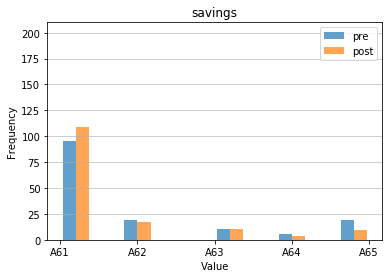

old


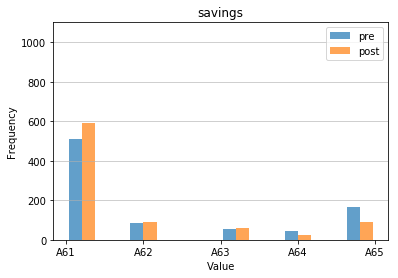

In [16]:
print("young")
plot.plot_mutable_features(sim,selection_criteria={'age':0})
print("old")
plot.plot_mutable_features(sim,selection_criteria={'age':1})

### Comments
Statistical parity difference improved.

In [17]:
df = sim.dataset_df
unique_elements, counts_elements = np.unique(df[df['age'] == 0]['status'], return_counts=True)
print(unique_elements, counts_elements/sum(counts_elements))

unique_elements, counts_elements = np.unique(df[df['age'] == 1]['status'], return_counts=True)
print(unique_elements, counts_elements/sum(counts_elements))

['A11' 'A12' 'A13' 'A14'] [0.38255034 0.30872483 0.05369128 0.25503356]
['A11' 'A12' 'A13' 'A14'] [0.25499412 0.26204465 0.06462985 0.41833137]


Above shows, that young people have less money in their bank account. Bank account balance is quite relevant for the output. Thus we can still infer age via bank account.

After playing around with the other fairness measures on the web application, I doubt that any of those will change this outcome for this particular dataset + protected attribute.

Other options: (basically do some actual affirmative action)
- play around with thresholds, see what happens
- different cost distribution, subsidize skill investement (feature manipulation)
- 
All the fairness measures in AIF360 are not affirmative action

In [18]:
from sklearn.linear_model import LogisticRegression

print(sim.dataset.label_names)
reg = LogisticRegression(solver='liblinear',max_iter=1000000000,C=1000000000000000000000.0).fit(sim.dataset.features, sim.dataset.labels.ravel())

df = pd.DataFrame(data=sim.dataset.features, columns=sim.dataset.feature_names)
data = plot._df_selection(df, {'age': 1})
print(list(reg.predict([data.values[0]])))

# next steps: implement modified decision function that enforces statistical parity...

['credit']
[1.0]


## Enforce Statistical Parity (threshold boost for unprivileged)

In [19]:
from learner import StatisticalParityLogisticLearner

g = GermanSimDataset(mutable_features=['savings'],
                     domains={'savings': 'auto', 'status': 'auto'},
                     discrete=['status', 'savings'],
                     protected_attribute_names=['age'],
                     privileged_classes=[lambda x: x >= 25],
                     features_to_drop=['personal_status', 'sex'])

privileged_groups = [{'age': 1}]
unprivileged_groups = [{'age': 0}]

sim = Simulation(g,
                 RationalAgent,
                 StatisticalParityLogisticLearner(privileged_groups,
                                           unprivileged_groups, 0.0000001),
                 lambda size: np.abs(np.random.normal(loc=1.0,size=size)))
 
sim.start_simulation(include_protected=True)

Train:  (500, 57) , Test:  (500, 57)
{'age': 1}


/home/dan/data/ETH/ba/simulation/mutabledataset.py:84: UserWarning: Use set of values present in dataset to infer domain for feature savings
  warnings.warn("Use set of values present in dataset to infer domain for feature " + ft)
/home/dan/data/ETH/ba/simulation/mutabledataset.py:84: UserWarning: Use set of values present in dataset to infer domain for feature status
  warnings.warn("Use set of values present in dataset to infer domain for feature " + ft)


Accuracy (h) pre 0.616
Accuracy (h) post 0.71
{'age': 1}
Accuracy (h*) post 0.712
eps =  0.0
y=1 785.0  <-  700.0


### Young, Old (Pre Simulation)

In [20]:
print_table(sim.dataset_df)

,Good Credit,Bad Credit
Young (149),81.208054,18.791946
Old (851),77.790834,22.209166


### Young, Old (Post Simulation)

In [21]:
print_table(sim.dataset_new_df)

,Good Credit,Bad Credit
Young (149),89.261745,10.738255
Old (851),86.486486,13.513514


### Mutable Features

young


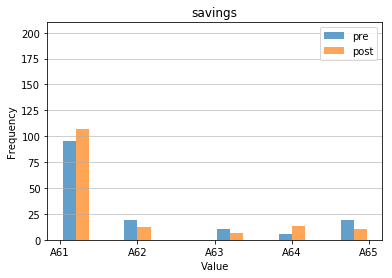

old


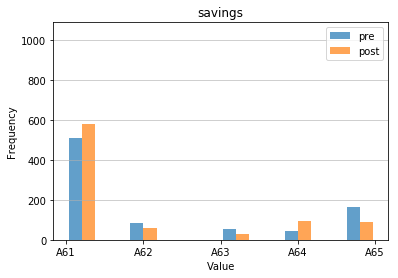

In [22]:
print("young")
plot.plot_mutable_features(sim,selection_criteria={'age':0})
print("old")
plot.plot_mutable_features(sim,selection_criteria={'age':1})

# Adversial Debiasing

In [23]:
from learner import AdversialDebiasingLogisticLearner

g = GermanSimDataset(mutable_features=['status', 'savings'],
                     domains={'savings': 'auto', 'status': 'auto'},
                     discrete=['status', 'savings'],
                     protected_attribute_names=['age'],
                     privileged_classes=[lambda x: x >= 25],
                     features_to_drop=['personal_status', 'sex'])

privileged_groups = [{'age': 1}]
unprivileged_groups = [{'age': 0}]

sim = Simulation(g,
                 RationalAgent,
                 AdversialDebiasingLogisticLearner(privileged_groups = privileged_groups,
                          unprivileged_groups = unprivileged_groups),
                 lambda size: np.abs(np.random.normal(loc=0.5,size=size)))
 
sim.start_simulation(include_protected=True)

ImportError: cannot import name 'AdversialDebiasingLogisticLearner' from 'learner' (/home/dan/data/ETH/ba/simulation/learner.py)

### Young, Old (Pre Simulation)

In [ ]:
print_table(sim.dataset_df)

### Young, Old (Post Simulation)

In [ ]:
print_table(sim.dataset_new_df)

# EqOdds Postprocessing

In [ ]:
from learner import EqOddsPostprocessingLogisticLearner

g = GermanSimDataset(mutable_features=['status', 'savings'],
                     domains={'savings': 'auto', 'status': 'auto'},
                     discrete=['status', 'savings'],
                     protected_attribute_names=['age'],
                     privileged_classes=[lambda x: x >= 25],
                     features_to_drop=['personal_status', 'sex'])

privileged_groups = [{'age': 1}]
unprivileged_groups = [{'age': 0}]

sim = Simulation(g,
                 RationalAgent,
                 EqOddsPostprocessingLogisticLearner(privileged_groups = privileged_groups,
                          unprivileged_groups = unprivileged_groups),
                 lambda size: np.abs(np.random.normal(loc=0.5,size=size)))
 
sim.start_simulation(include_protected=True)

### Young, Old (Pre Simulation)

In [ ]:
print_table(sim.dataset_df)

### Young, Old (Post Simulation)

In [ ]:
print_table(sim.dataset_new_df)